In [2]:
# Standard library imports
import os

# Third party imports
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [3]:
# Define the dataset name (from the Kaggle URL) and the destination directory
dataset_name = 'binovi/wholesale-customers-data-set'
destination_directory = '../data'

# Download and extract the dataset
kaggle.api.dataset_download_files(dataset_name, path=destination_directory, unzip=True)

print("Download and extraction completed. Files are available in:", destination_directory)


Download and extraction completed. Files are available in: ../data


## Data Exploration

In [4]:
# Load the CSV file into a Pandas DataFrame
file_path = os.path.join(destination_directory, 'Wholesale customers data.csv')
df = pd.read_csv(file_path)


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
df.head()
df.tail()
df.sample()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
80,1,3,7005,829,3009,430,610,529


The dataset contains the following columns: Channel, Region, Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicassen. Each row seems to represent a client of the wholesale distributor, with numerical values indicating annual spending in different product categories.

Doble check for duplicates and missing values

In [7]:
df.duplicated().sum()


0

In [8]:
df.isnull().sum()


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Summary statistics.

In [9]:
df.describe()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


The dataset does not have any missing values, which is great as it simplifies the pre-processing step. The summary statistics provide an initial understanding of the data distribution across different features. 

Some observations from the summary:
The Channel and Region features are categorical with small integer ranges.
The remaining features have a wide range of values with significant differences between the 75th percentile and the maximum values, indicating potential outliers.

Data Visualization

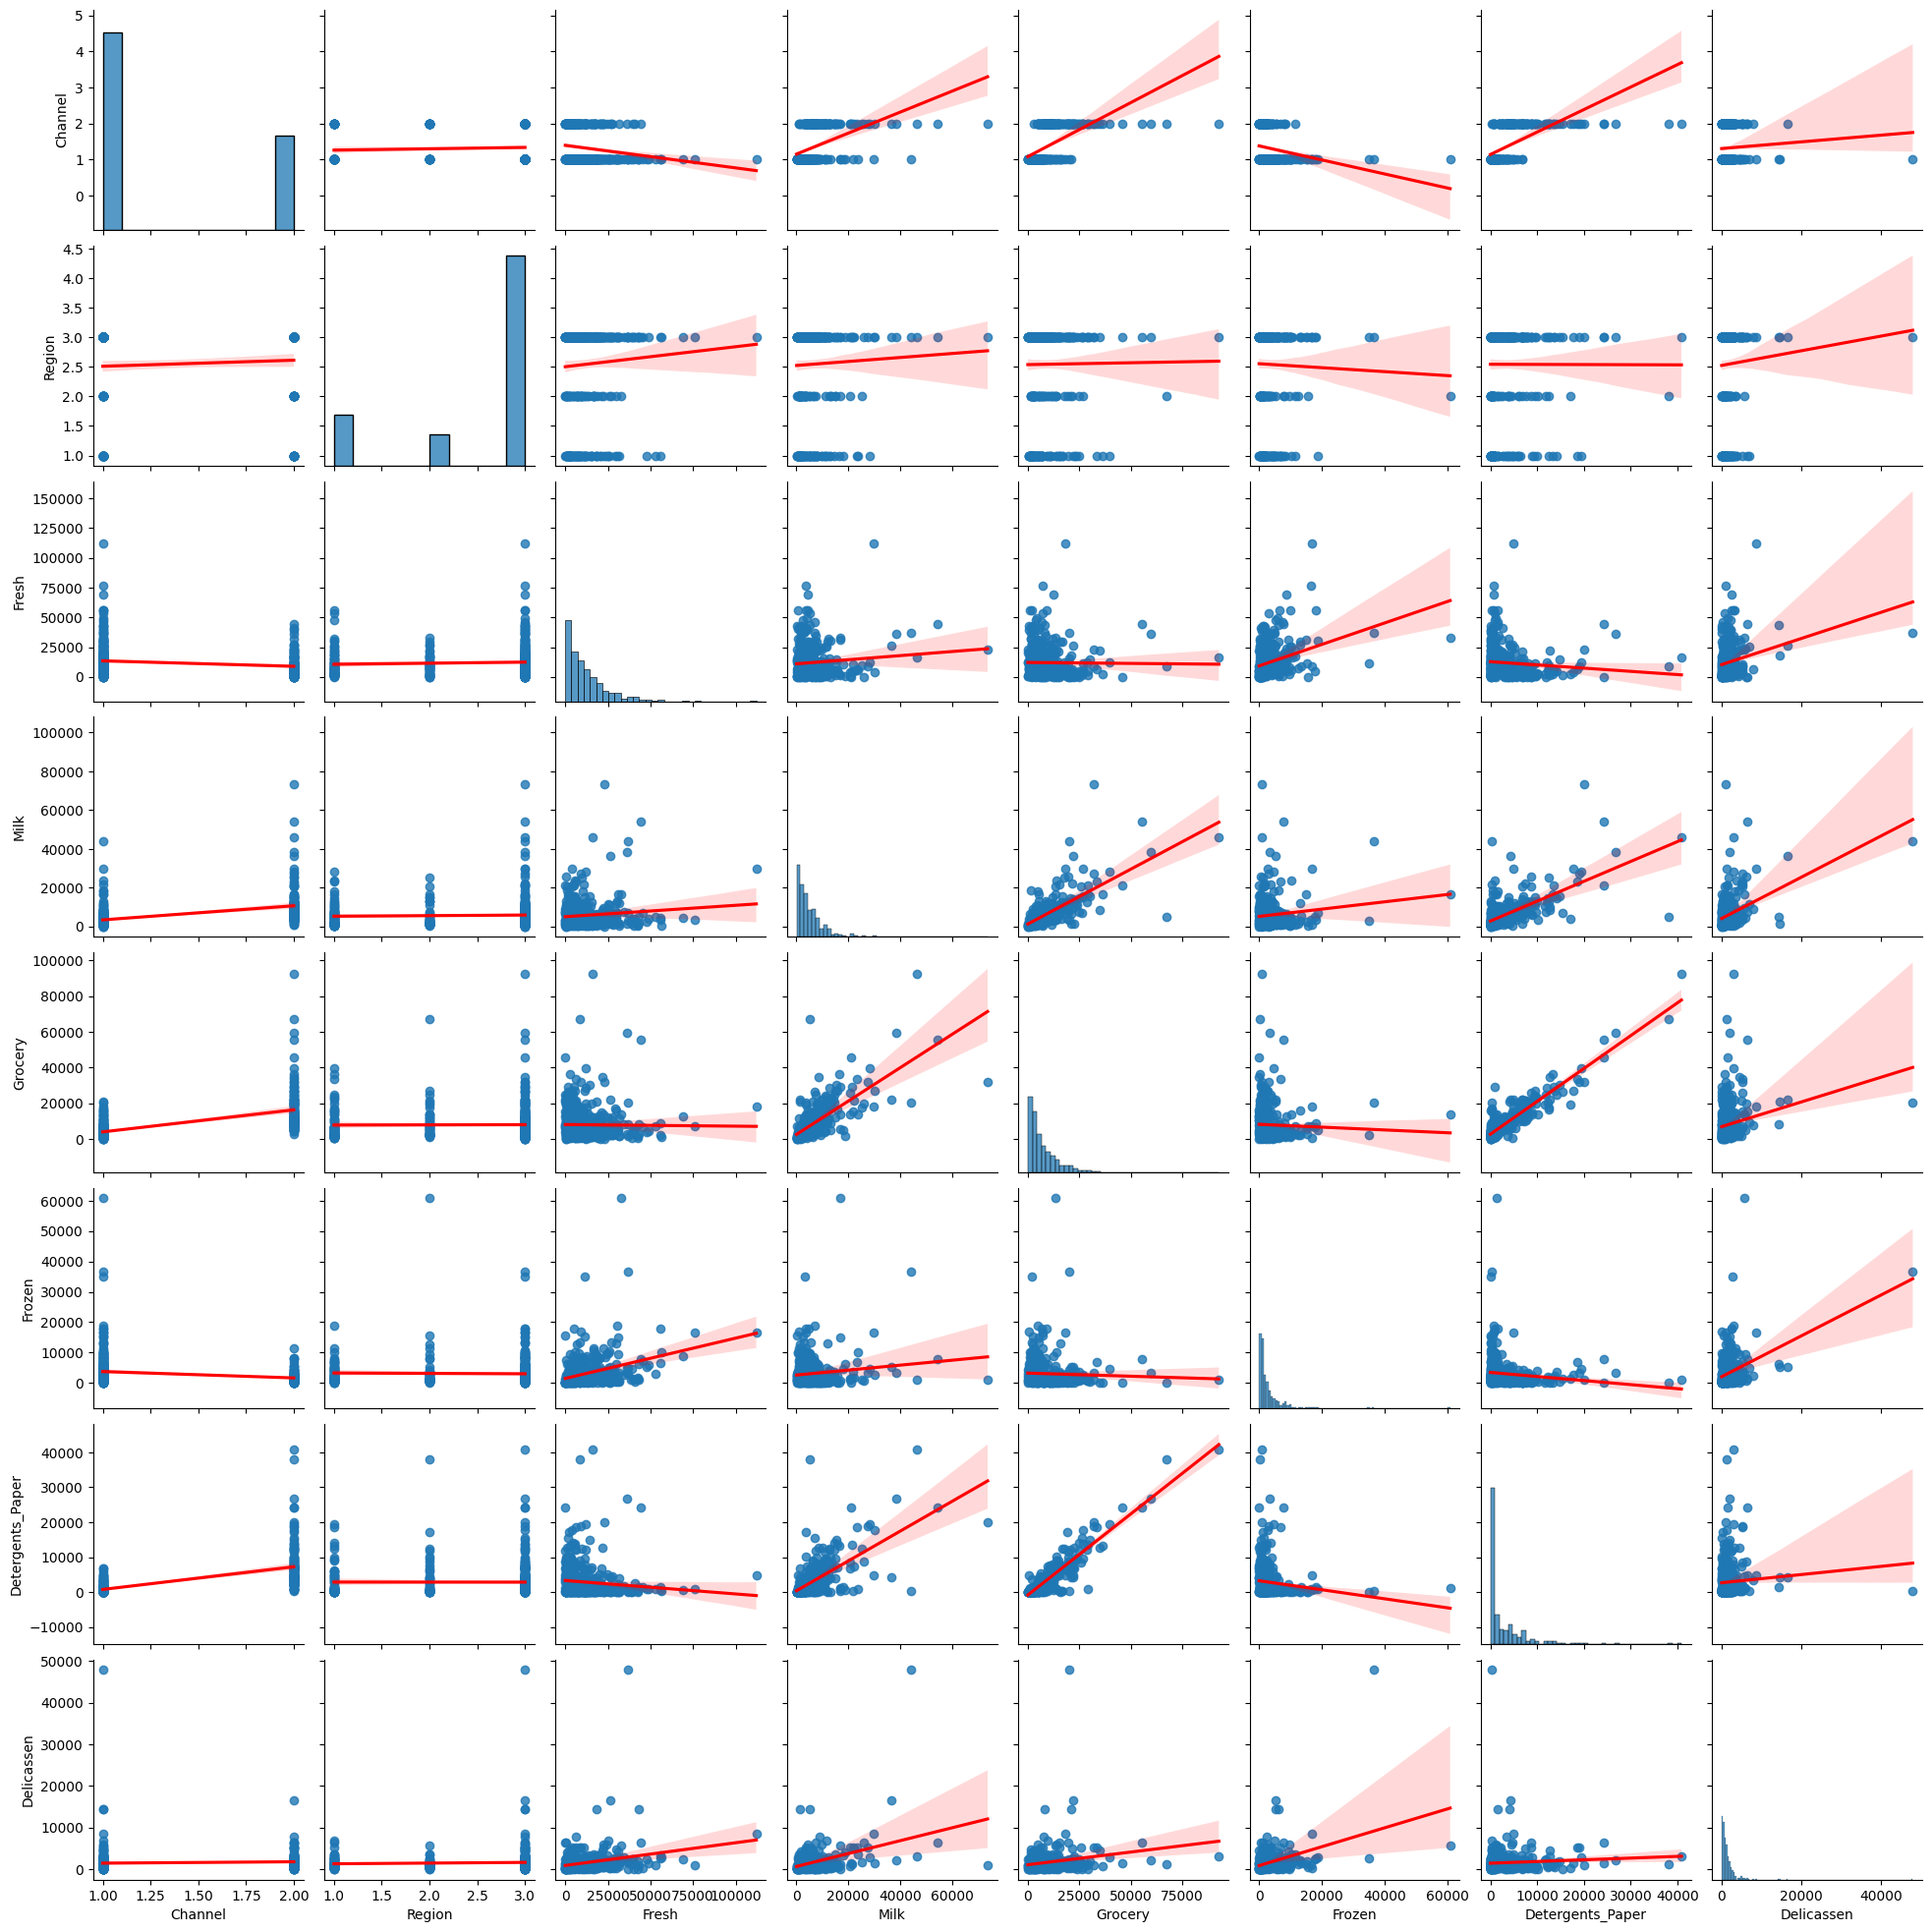

In [10]:
sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.show()


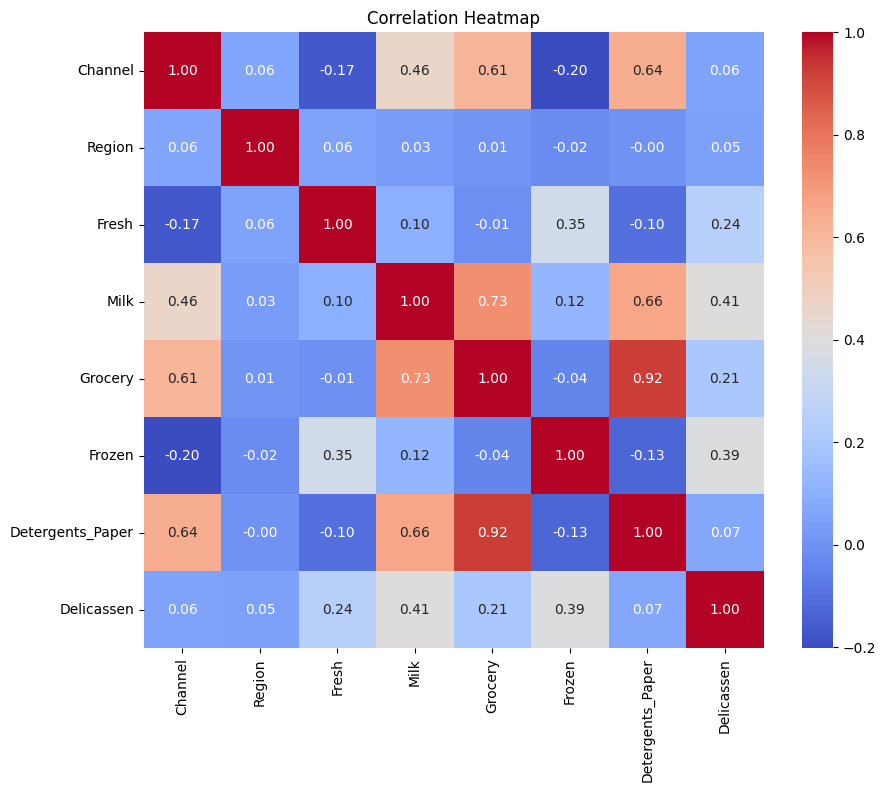

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


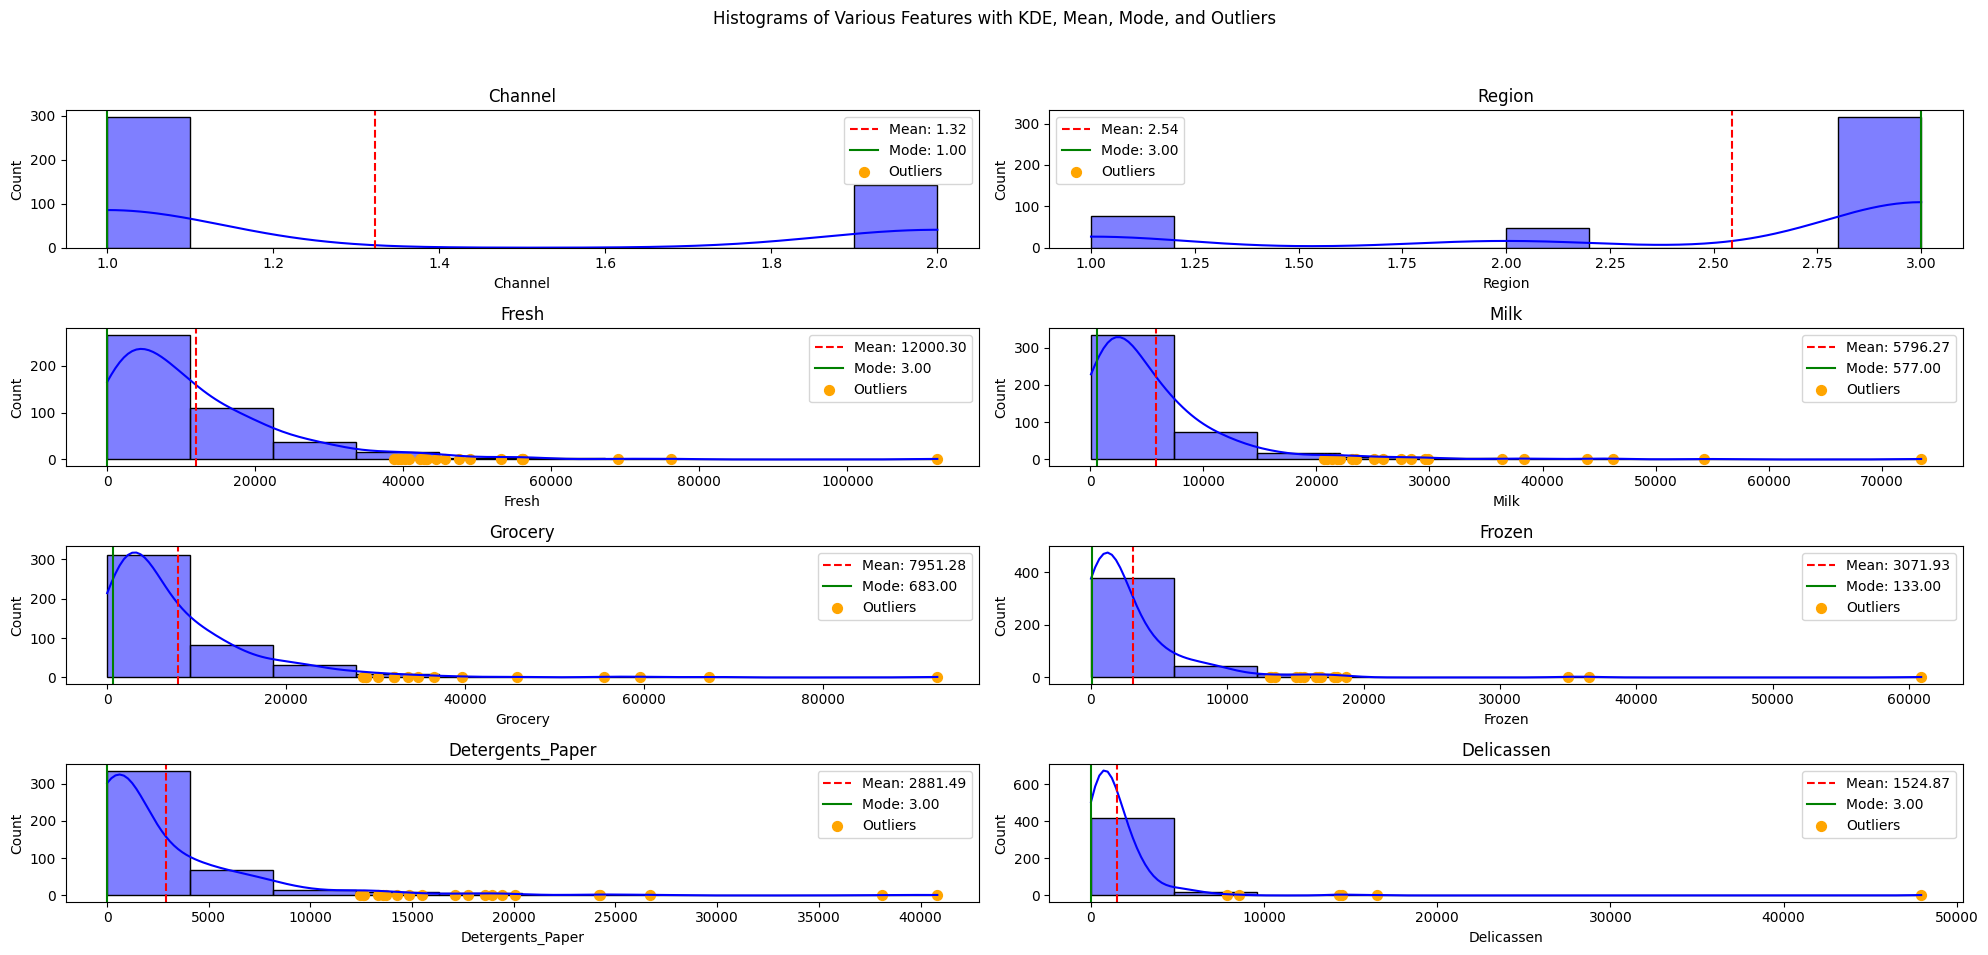

In [12]:
# Assuming df is your DataFrame
fig, axes = plt.subplots(4, 2, figsize=(20, 10))
axes = axes.flatten()

for ax, col in zip(axes, df.columns):
    # Histogram and KDE
    sns.histplot(df[col], bins=10, kde=True, color='blue', edgecolor='black', ax=ax)

    # Mean and Mode
    mean = df[col].mean()
    mode = df[col].mode()[0]
    ax.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    ax.axvline(mode, color='green', linestyle='-', label=f'Mode: {mode:.2f}')

    # Outliers
    std_dev = df[col].std()
    outliers = df[col][np.abs(df[col] - mean) > 2 * std_dev]
    ax.scatter(outliers, np.zeros_like(outliers) - 0.01, color='orange', s=50, label='Outliers')

    ax.legend()
    ax.set_title(col)

plt.suptitle("Histograms of Various Features with KDE, Mean, Mode, and Outliers")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Valuable Insights:

Histograms show the distribution of values for each feature. 
Many features display a right-skewed distribution, suggesting the presence of outliers.

The correlation heatmap reveals relationships between features. 
For instance, Grocery and Detergents_Paper seem to have a strong positive correlation, as do Grocery and Milk.

Outliers

Given the skewed distributions, outliers might be affecting these patterns. 
We'll use the Interquartile Range (IQR) method to identify outliers.

In [13]:
# Detect outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)))

# Count the number of outliers in each column
outliers_count = outlier_condition.sum()
outliers_count

# Remove rows containing outliers
df_no_outliers = df[~outlier_condition.any(axis=1)]

# New shape of the dataset
new_shape = df_no_outliers.shape
outliers_count, new_shape


(Channel              0
 Region               0
 Fresh               20
 Milk                28
 Grocery             24
 Frozen              43
 Detergents_Paper    30
 Delicassen          27
 dtype: int64,
 (332, 8))

Outliers Insights

Outliers are present in the Fresh, Milk, Grocery, Frozen, Detergents_Paper, and Delicassen columns.
The outliers are mostly concentrated in the lower end of the range.
The number of outliers in each column varies from 20 to 43.

After removing rows containing these outliers, the dataset size has reduced to 332 entries from the original 440.
This reduction in dataset size should help in focusing the analysis on more typical data patterns.

Data Normalization

The final step in our pre-processing is data normalization. Given the different scales of the data, normalization is crucial for algorithms like KMeans clustering that are sensitive to the scale of the data.

Let's normalize the data using the Min-Max Scaler, which scales the data to a range of [0, 1]. This approach preserves the shape of the dataset's distribution and is useful when we need to transform features into a range on the same scale.

In [14]:
# Initialize Min-Max Scaler
scaler = MinMaxScaler()

# Scale the data
scaled_data = scaler.fit_transform(df_no_outliers)

# Create a new DataFrame with the scaled data
scaled_wholesale_df = pd.DataFrame(scaled_data, columns=df_no_outliers.columns)

# Display the first few rows of the scaled DataFrame
scaled_wholesale_df.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.342019,0.643197,0.339396,0.024680,0.297903,0.367364
1,1.0,1.0,0.190479,0.653514,0.429521,0.226822,0.366942,0.487892
2,0.0,1.0,0.358113,0.076439,0.189411,0.832985,0.056212,0.491194
3,1.0,1.0,0.254098,0.549608,0.230051,0.083703,0.199866,0.398459
4,1.0,1.0,0.327357,0.210625,0.313081,0.059415,0.349877,0.149147


The data has been successfully pre-processed and is now ready for clustering.

Normalization was done using the Min-Max Scaler, with each feature now ranging between 0 and 1. This normalization will facilitate the use of algorithms that are sensitive to the scale of the data, such as KMeans clustering.

## Clustering

First, we'll use the elbow method to determine the optimal number of clusters for KMeans. This involves fitting the KMeans algorithm to the data for a range of cluster numbers and then plotting the inertia (sum of squared distances to the nearest cluster center) to find the 'elbow' point, where the inertia starts to decrease more slowly.

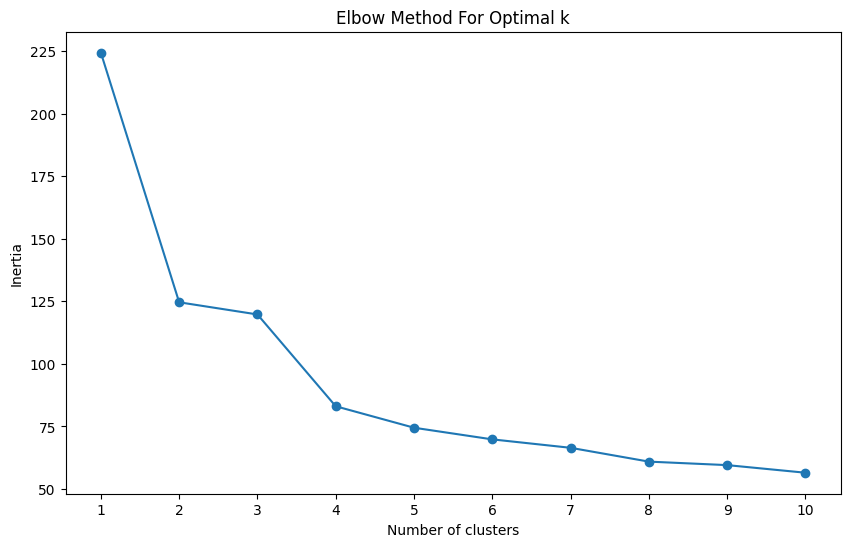

In [15]:
# Range of potential clusters
cluster_range = range(1, 11)

# Calculate inertia for each number of clusters
inertia = []
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_wholesale_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method For Optimal k")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.xticks(cluster_range)
plt.show()


The elbow graph provides a visual guide to help us choose the optimal number of clusters. 
Typically, the 'elbow' point is where the inertia starts to decrease at a slower rate. 
Based on the graph, this point seems to occur around 4 or 5 clusters.

We'll now apply KMeans clustering with 5 clusters and then analyze the resulting clusters. 
This involves examining the centroids of the clusters to understand the defining characteristics of each cluster.

In [ ]:
# Applying KMeans clustering
optimal_clusters = 5
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_wholesale_df)

# Retrieve the cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the original scaled dataframe
scaled_wholesale_df['Cluster'] = cluster_labels

# Displaying the mean value of each feature for each cluster
cluster_characteristics = scaled_wholesale_df.groupby('Cluster').mean()
cluster_characteristics


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,,,
0,1.000000,0.875000,0.286795,0.517515,0.479150,0.152078,0.452936,0.621644
1,0.014493,0.123188,0.270603,0.176186,0.170681,0.305830,0.096998,0.243079
2,1.000000,0.844828,0.178232,0.486271,0.552596,0.171176,0.604964,0.199348
3,0.000000,0.972727,0.496560,0.240259,0.179069,0.461860,0.075029,0.369365
4,0.000000,0.991228,0.165972,0.156816,0.145849,0.155947,0.089600,0.189239


The analysis provides a basic understanding of the different types of wholesale clients in the dataset based on their spending patterns.
The cluster characteristics provide insights into different customer segments:

Cluster 0: Customers in this cluster have below-average spending in all categories. This could represent smaller outlets or individual buyers.

Cluster 1: This cluster shows high spending on Milk, Grocery, and Detergents_Paper, suggesting these might be larger grocery stores or supermarkets.

Cluster 2: Customers here have moderate spending across all categories, with a slightly higher focus on Fresh and Frozen products. This could indicate restaurants or cafes.

Cluster 3: This cluster is characterized by high spending on Fresh and Delicassen, and above-average spending on Frozen. These could be specialty food stores or delis.

Cluster 4: Similar to Cluster 1, but with even higher spending on Milk, Grocery, and Detergents_Paper, and lower spending on Fresh and Frozen. This could represent large retail chains or hypermarkets.

Hierarchical clustering

This method for identifies clusters in data. 
It doesn't require pre-specifying the number of clusters. 
Instead, it creates a dendrogram (tree-like diagram) that shows the arrangement of the clusters formed at each level.

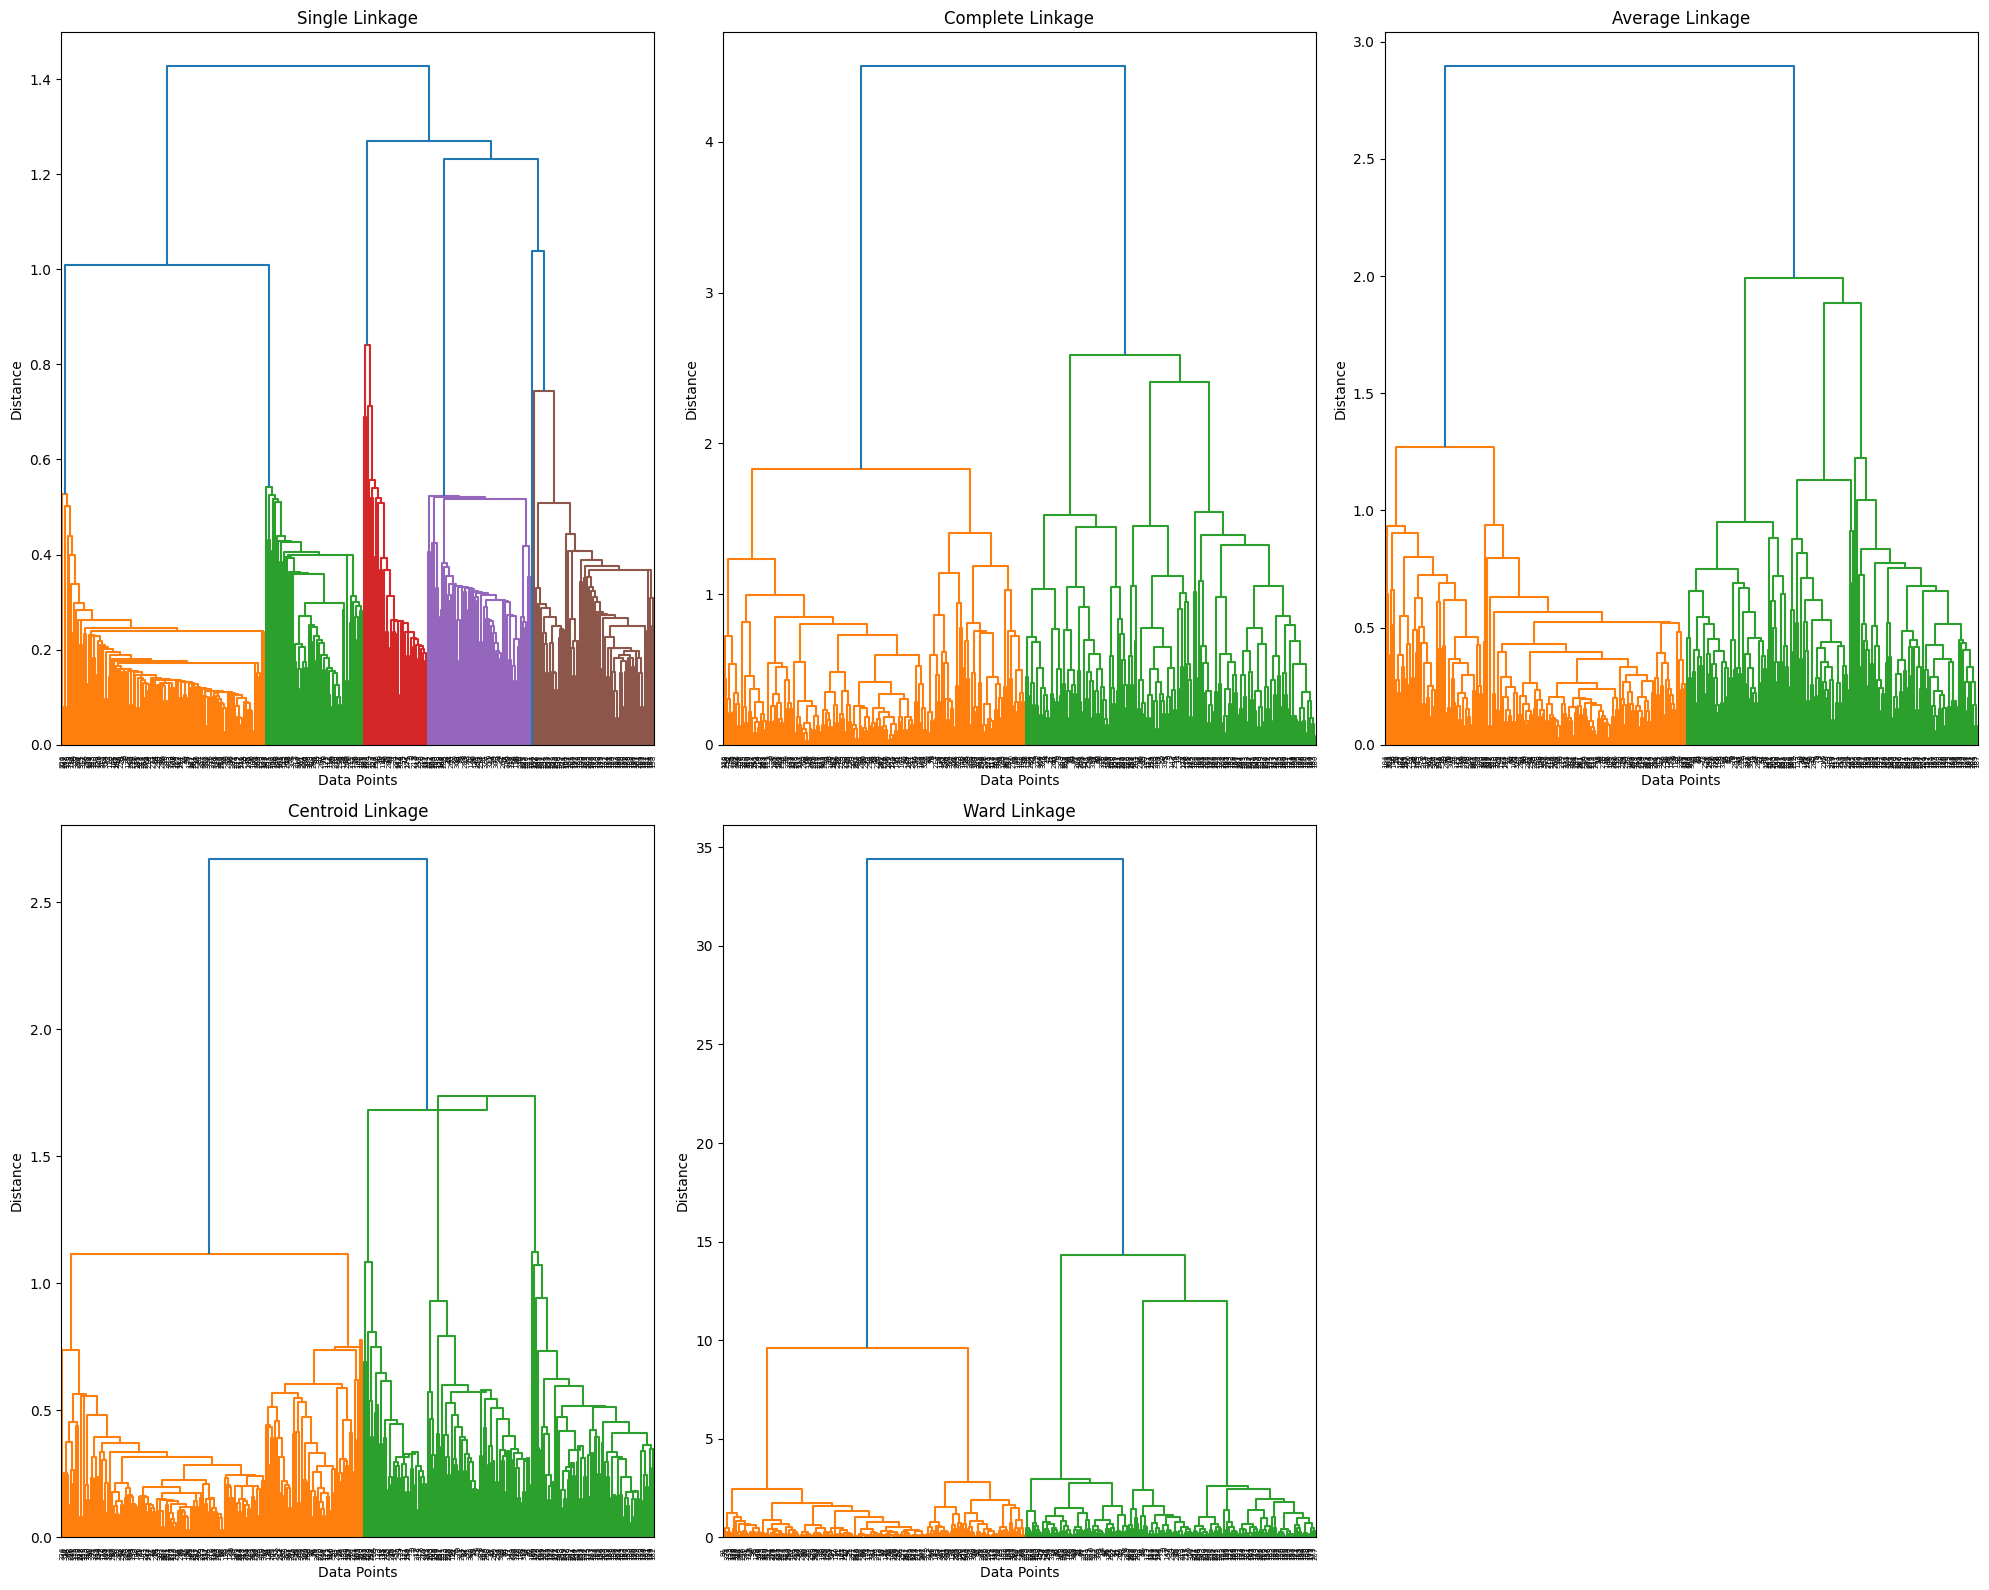

In [ ]:
# Determine the ideal number of clusters to use with AgglomerativeClustering by plotting a Dendrogram

# Plot a dendrogram for each linkage method
methods = ['single', 'complete', 'average', 'centroid', 'ward']
linkages = {method: linkage(scaled_wholesale_df, method=method) for method in methods}

# Plot dendrograms for each linkage method
plt.figure(figsize=(20, 16))
for i, method in enumerate(methods, start=1):
    plt.subplot(2, 3, i)
    dendrogram(linkages[method])
    plt.title(f'{method.capitalize()} Linkage')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()


The dendrogram from hierarchical clustering provides a visual representation of the data points and their respective similarities. 
To determine the number of clusters, we can look for the largest vertical distance that we can draw without crossing any horizontal lines. 

Based on the dendrogram, a reasonable choice for the number of clusters might be around 2 to 5.

We will fit Agglomerative Clustering with 4 clusters and then analyze the cluster characteristics similarly to what we did with KMeans.


In [ ]:
# Fit Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
agg_clusters = agg_clustering.fit_predict(scaled_wholesale_df)

# Add cluster labels to the DataFrame
scaled_wholesale_df['AggCluster'] = agg_clusters

# Displaying the mean value of each feature for each Agglomerative cluster
agg_cluster_characteristics = scaled_wholesale_df.groupby('AggCluster').mean()
print(agg_cluster_characteristics)


             Channel    Region     Fresh      Milk   Grocery    Frozen  \
AggCluster                                                               
0           0.000000  0.985207  0.273560  0.183972  0.156661  0.255505   
1           0.014493  0.123188  0.270603  0.176186  0.170681  0.305830   
2           1.000000  0.844828  0.178232  0.486271  0.552596  0.171176   
3           1.000000  0.875000  0.286795  0.517515  0.479150  0.152078   

            Detergents_Paper  Delicassen   Cluster  
AggCluster                                          
0                   0.084858    0.247860  3.674556  
1                   0.096998    0.243079  1.000000  
2                   0.604964    0.199348  2.000000  
3                   0.452936    0.621644  0.000000  


Cluster 0: Higher average spending on Fresh and Delicassen, with moderate spending on Milk, Grocery, and Detergents_Paper. This cluster might represent quality-focused stores like gourmet food shops.

Cluster 1: Similar to one of the KMeans clusters, showing high spending on Milk, Grocery, and Detergents_Paper. Likely represents large supermarkets or grocery stores.

Cluster 2: Low spending across all categories, possibly representing small retailers or individual consumers.

Cluster 3: Moderate spending on Fresh, Frozen, and Delicassen, likely indicating restaurants or cafes specializing in fresh and frozen foods.

PCA (Principal Component Analysis)

PCA is used for dimensionality reduction while preserving as much of the data's variance as possible. 
It can also help identify the most important features in the dataset.
We will apply PCA to the scaled dataset to reduce the number of features and visualize the explained variance by each principal component.
This will give us an idea of how many principal components we should consider for capturing the significant information from the dataset.

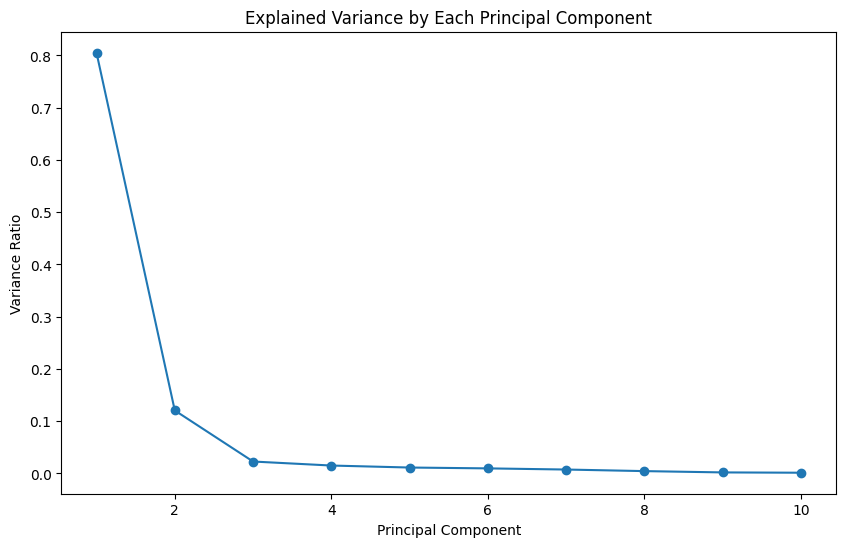

In [ ]:
# Apply PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_wholesale_df)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.show()


The plot of explained variance by each principal component helps us understand the contribution of each principal component to the total variance in the dataset. 
A few initial components usually capture the most significant portion of the variance.
The plot suggests that the first few principal components account for a large percentage of the variance. 


Evaluate Performance of PCA by calculating its Reconstruction Error

Number of Components: 1, Reconstruction Error (MSE): 0.07358009029051689
Number of Components: 2, Reconstruction Error (MSE): 0.028045345770556774
Number of Components: 3, Reconstruction Error (MSE): 0.01942694317995746
Number of Components: 4, Reconstruction Error (MSE): 0.013711538271838256
Number of Components: 5, Reconstruction Error (MSE): 0.009435158667338035
Number of Components: 6, Reconstruction Error (MSE): 0.005777469907075816
Number of Components: 7, Reconstruction Error (MSE): 0.0029524494017693663
Number of Components: 8, Reconstruction Error (MSE): 0.00126673587846395
Number of Components: 9, Reconstruction Error (MSE): 0.0005217704394611456
Number of Components: 10, Reconstruction Error (MSE): 1.781275270978751e-31


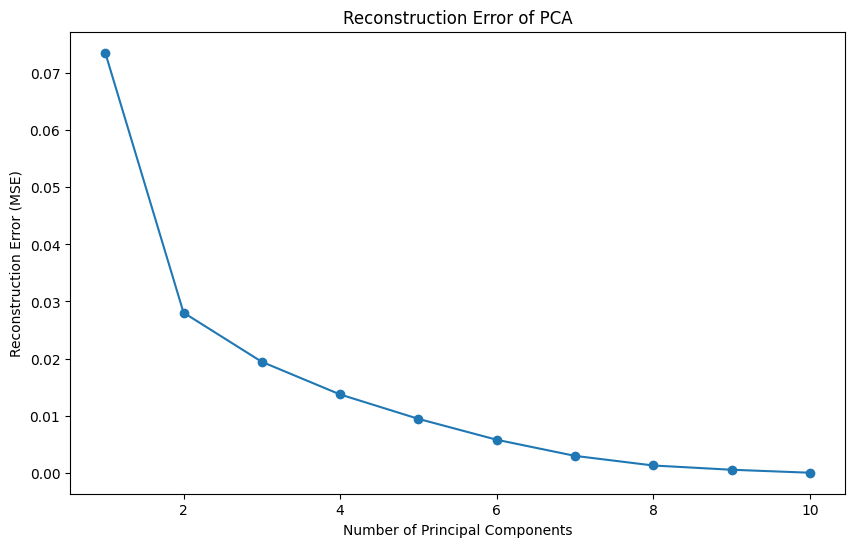

In [ ]:
# Initialize list to store reconstruction errors
reconstruction_errors = []

# Loop over various numbers of principal components
for num_components in range(1, pca.n_components_ + 1):
    # Apply inverse transform to reconstruct the data
    pca = PCA(n_components=num_components)
    pca.fit(scaled_wholesale_df)
    reconstructed_data = pca.inverse_transform(pca.transform(scaled_wholesale_df))
    
    # Calculate the reconstruction error
    mse = mean_squared_error(scaled_wholesale_df, reconstructed_data)
    reconstruction_errors.append(mse)
    print(f"Number of Components: {num_components}, Reconstruction Error (MSE): {mse}")

# Plotting the reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), reconstruction_errors, marker='o')
plt.title('Reconstruction Error of PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.show()


The reconstruction errors you've provided show how the error decreases as the number of principal components increases. 
This is a typical behavior in PCA: using more components captures more variance of the dataset, thereby reducing the reconstruction error.

Deeper Analysis of Principal Components

We will examine the principal components more closely to understand which original features contribute most to each principal component.
This can provide insights into the underlying structure of the data.
We'll look at the loadings (or weights) of the original features on each principal component to understand which features have the most influence on each component

In [ ]:
# Number of components to analyze
num_components = 5

# Get the loadings of the original features on each principal component
loadings = pd.DataFrame(pca.components_.T[:, :num_components], columns=[f'PC{i+1}' for i in range(num_components)], index=scaled_wholesale_df.columns)

# Display the loadings
loadings


,PC1,PC2,PC3,PC4,PC5
Channel,0.185166,-0.449620,0.041066,-0.054454,0.220823
Region,-0.093482,-0.398460,-0.702731,-0.186093,-0.055365
Fresh,0.004442,0.085062,-0.438498,0.039756,-0.014682
Milk,0.062417,-0.154841,-0.001301,0.517394,-0.063756
Grocery,0.067617,-0.184519,0.081663,0.492284,-0.002215
Frozen,-0.004888,0.115533,-0.261870,0.153331,0.886684
Detergents_Paper,0.079614,-0.239748,0.183379,0.446721,0.106508
Delicassen,0.046608,-0.007990,-0.403209,0.387573,-0.381206
Cluster,-0.787466,-0.483850,0.170937,-0.038110,0.031229
AggCluster,0.565553,-0.518470,0.107382,-0.275767,-0.006465


Visual Representation

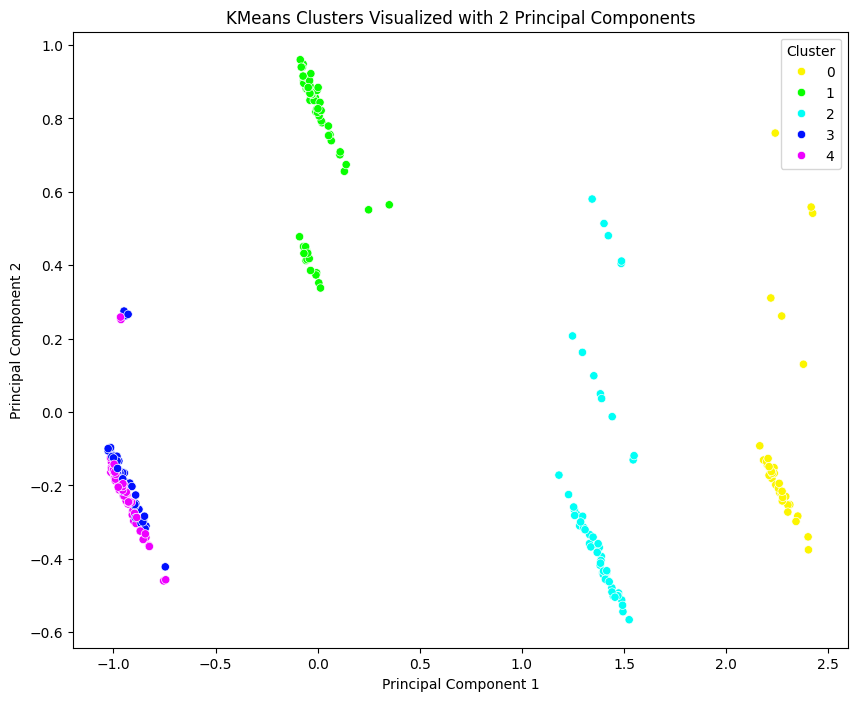

In [ ]:
# Performing PCA for dimensionality reduction
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_wholesale_df.drop('Cluster', axis=1))

# Creating a DataFrame for the PCA results
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette=sns.color_palette("hsv", optimal_clusters), data=pca_df)

# Adding plot title and labels
plt.title('KMeans Clusters Visualized with 2 Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()


The loadings table shows how each original feature contributes to each of the first five principal components (PCs). 
Here's a summary of the most influential features for each component:

PC1: The Cluster feature has the highest loading, followed by AggCluster. This indicates that the clusters we derived earlier heavily influence this component.

PC2: The AggCluster and Region features have the highest loadings, suggesting regional differences and the Agglomerative clusters significantly influence this component.

PC3: Features like Channel, Grocery, and Detergents_Paper have high loadings, indicating these features' importance in this component.

PC4: The Delicassen feature has the highest loading, followed by Fresh. This component seems to capture variations related to these categories

PC5: The Fresh and Frozen categories have high loadings, indicating their importance in this component.

These insights can help in understanding the underlying patterns in the data. 
For instance, the significant influence of clustering results (both KMeans and Agglomerative) in PC1 and PC2 suggests that the clusters are a meaningful way to understand the data.

## Conclusion and Insights

Customer Segmentation: Both KMeans and Agglomerative Clustering revealed distinct customer segments based on their purchasing patterns, which can guide targeted marketing strategies and inventory management.

Milk and Grocery have a really good correlation. Suggesting these two are bought together.

Influential Features: The PCA analysis highlighted features like Milk, Grocery, Detergents_Paper, Delicassen, and Fresh as significant in explaining the variance in the dataset, which aligns with the observed correlations in the EDA phase.

Regional Differences: The PCA and clustering analyses suggest regional differences in purchasing patterns, which could be important for regional marketing strategies.

Utility of PCA: The PCA analysis reduced the dataset's dimensionality while retaining significant variance, making it useful for further analysis or predictive modeling.

This project provided valuable insights into the wholesale distributor's client base, which can be leveraged for data-driven decision-making in various business operations.